In [8]:
%load_ext autoreload
%autoreload 2
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import SVG
from krxns.cheminfo import draw_molecule, draw_reaction, expand_unpaired_cofactors
from krxns.config import filepaths
from krxns.rxn_cxn import connect_reaction_w_operator, SimilarityConnector, extract_compounds
import json
from itertools import chain
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Atoms which are just copied over directly from the reactants (those which were not mapped in the reaction) will still have the reactant_idx property set.
The reacting atoms will have the old_mapno property set, and you can lookup which reactant those came from in the atomMapToReactantMap dictionary.

Operator


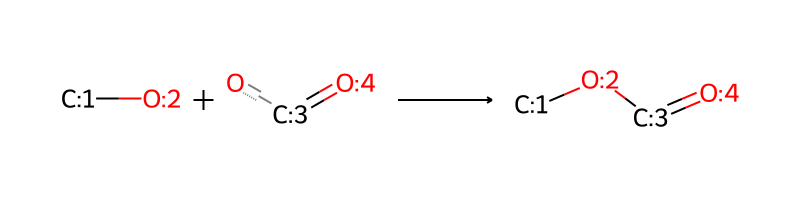

Reactants


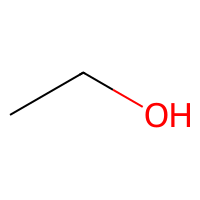

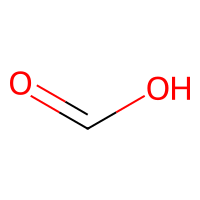

An output


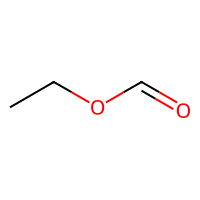

0 6 {'old_mapno': 1, 'react_atom_idx': 1}
1 8 {'_ReactionDegreeChanged': 1, 'old_mapno': 2, 'react_atom_idx': 2}
2 6 {'old_mapno': 3, 'react_atom_idx': 1}
3 8 {'old_mapno': 4, 'react_atom_idx': 2}
4 6 {'__computedProps': <rdkit.rdBase._vectSs object at 0x7f9bb09e2540>, '_CIPRank': 0, 'reactant_idx': 0, 'react_atom_idx': 0}
{1: 0, 2: 0, 3: 1, 4: 1}


In [2]:
# Greg Landrum demo

rxn = Chem.rdChemReactions.ReactionFromSmarts('[C:1]-[O:2].[C:3](=[O:4])[OH]>>[C:1]-[O:2]-[C:3]=[O:4]')
print("Operator")
display(SVG(draw_reaction(rxn)))

print("Reactants")
reactants = [Chem.MolFromSmiles(x) for x in ('CCO','OC=O')]
for r in reactants:
    display(SVG(draw_molecule(r)))

for i,m in enumerate(reactants):
    for atom in m.GetAtoms():
        atom.SetIntProp('reactant_idx',i)

print("An output")
ps = rxn.RunReactants(reactants)
p0 = ps[0][0]
display(SVG(draw_molecule(p0)))
for atom in p0.GetAtoms():
    print(atom.GetIdx(), atom.GetAtomicNum(), atom.GetPropsAsDict())

atomMapToReactantMap={}
for ri in range(rxn.GetNumReactantTemplates()):
    rt = rxn.GetReactantTemplate(ri)
    for atom in rt.GetAtoms():
        if atom.GetAtomMapNum():
            atomMapToReactantMap[atom.GetAtomMapNum()] = ri

print(atomMapToReactantMap)

These reactions have been mapped with both IMT and MIN operators, reaction centers stored, order of reactants and products both aligned the order they appear in the operator (each reaction and its reverse are reconciled).

In [9]:
# Load known reaction data
with open(filepaths['data'] / "sprhea_240310_v3_mapped.json", 'r') as f:
    known_reactions = json.load(f)

known_reactions = {int(k): v for k,v in known_reactions.items()}

# Load operators
ops = pd.read_csv(filepath_or_buffer=filepaths['operators'] / "imt_ops.tsv",
                  sep='\t'
).set_index("Name")


# Check op map frac
unmapped = {k: v for k,v in known_reactions.items() if not v['imt_rules']}
print(len(unmapped) / len(known_reactions))

# Extract known compounds
known_compounds, smi2id = extract_compounds(known_reactions)

# Remove reverses
rids = set()
for k, v in known_reactions.items():
    rids.add(tuple(sorted([k, v['reverse']])))

keepers = [elt[0] for elt in rids]

known_reactions = {k: known_reactions[k] for k in keepers}
print(len(known_reactions))

0.4238853178247118
9801


In [10]:
# Construct operator atom map num to rct idx look up

op_atom_map_to_rct_idx = {}
for op_name, row in ops.iterrows():

    atom_map_to_rct_idx = {}
    rxn = AllChem.ReactionFromSmarts(row["SMARTS"])
    for ri in range(rxn.GetNumReactantTemplates()):
        rt = rxn.GetReactantTemplate(ri)
        for atom in rt.GetAtoms():
            if atom.GetAtomMapNum():
                atom_map_to_rct_idx[atom.GetAtomMapNum()] = ri

    op_atom_map_to_rct_idx[op_name] = atom_map_to_rct_idx

Reactant inlinks: {0: {0: 1.0, 1: 0.0}, 1: {0: 0.0, 1: 1.0}, 2: {0: 1.0, 1: 0.0}}
Product inlinks: {0: {0: 0.6428571428571429, 1: 0.0, 2: 0.35714285714285715}, 1: {0: 0.0, 1: 1.0, 2: 0.0}}


[11:03:33] Explicit valence for atom # 1 O, 3, is greater than permitted
[11:03:33] Initializing MetalDisconnector
[11:03:33] Running MetalDisconnector
[11:03:33] Initializing Normalizer
[11:03:33] Running Normalizer
[11:03:33] Initializing MetalDisconnector
[11:03:33] Running MetalDisconnector
[11:03:33] Initializing Normalizer
[11:03:33] Running Normalizer


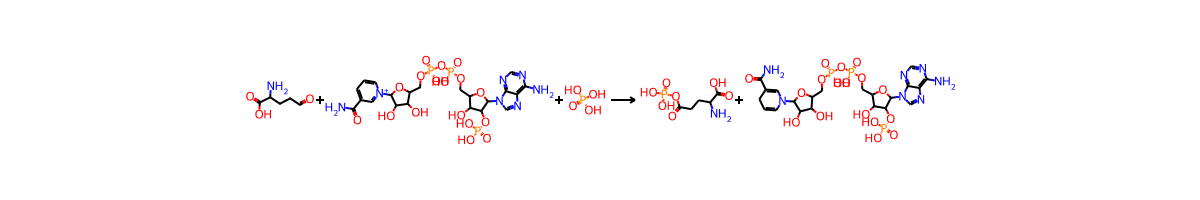

In [11]:
rid = 0
reaction = known_reactions[rid]["smarts"]
rule_name = known_reactions[rid]["imt_rules"][0]
operator = ops.loc[rule_name, "SMARTS"]
atom_map_to_rct_idx = op_atom_map_to_rct_idx[rule_name]
rct_inlinks, pdt_inlinks = connect_reaction_w_operator(reaction, operator, atom_map_to_rct_idx)
print(f"Reactant inlinks: {rct_inlinks}")
print(f"Product inlinks: {pdt_inlinks}")
display(SVG(draw_reaction(reaction)))

In [12]:
# Compare with similarity connector

# Load unpaired cofs
unpaired_fp = filepaths['cofactors'] / "unpaired_cofactors_reference.tsv"
name_blacklist = [
    'acetyl-CoA',
    'CoA'
]

unpaired_ref = pd.read_csv(
    filepath_or_buffer=unpaired_fp,
    sep='\t'
)

filtered_unpaired = unpaired_ref.loc[~unpaired_ref['Name'].isin(name_blacklist), :]
cofactors = expand_unpaired_cofactors(filtered_unpaired, k=k)

manual = {
    'N#N': 'N2',
    '[H][H]': 'H2',
    'S': 'hydrogen sufide',
    '[Cl-]': 'chloride',
    '[Na+]': 'sodium'
}

cofactors = {**cofactors, ** manual}

# Load cc sim mats
cc_sim_mats = {
    'mcs': np.load(filepaths['sim_mats'] / "mcs.npy"),
    'tanimoto': np.load(filepaths['sim_mats'] / "tanimoto.npy")
}

[11:03:34] WARNING: not removing hydrogen atom without neighbors


In [13]:
# Construct SimilarityConnector

sc = SimilarityConnector(
    reactions=known_reactions,
    cc_sim_mats=cc_sim_mats,
    cofactors=cofactors
)

rct_inlinks, pdt_inlinks = sc.connect_reaction(0)
translate = lambda x : {sc.compounds[outer]['name']: {sc.compounds[inner]['name']: inner_v  for inner, inner_v in outer_v.items()} for outer, outer_v in x.items()}
print(translate(rct_inlinks))
print(translate(pdt_inlinks))

/home/stef/krxns/krxns/rxn_cxn.py:116: RuntimeWarning: invalid value encountered in divide
  for rxn in self.reactions.values():


{'L-glutamate 5-semialdehyde': {'NADPH': 0, 'L-glutamyl 5-phosphate': 1}, 'NADP(+)': {'NADPH': 1, 'L-glutamyl 5-phosphate': 0}}
{'NADPH': {'L-glutamate 5-semialdehyde': 0, 'NADP(+)': 1}, 'L-glutamyl 5-phosphate': {'L-glutamate 5-semialdehyde': 1, 'NADP(+)': 0}}
